# Tobin's Q 
### The Q ratio, also known as Tobin's Q, equals the market value of a company divided by its assets' replacement cost. Thus, equilibrium is when market value equals replacement cost. At its most basic level, the Q Ratio expresses the relationship between market valuation and intrinsic value. In other words, it is a means of estimating whether a given business or market is overvalued or undervalued.
Source: [Investopedia](https://www.investopedia.com/terms/q/qratio.asp)

### We can use approximations for market value and replacement cost, per [Tobin's Q – Definition and History for the US Stock Market](https://dqydj.com/tobins-q/)

### Both estimates come from the Federal Reserve's Z.1 Financial Accounts of the United States Report (quarterly).

#### Market Value: Nonfinancial Corporate Business; Corporate Equities; Liability, Level (NCBEILQ027S)
#### Replacement Cost/Book Value: Nonfinancial Corporate Business; Net Worth, Level (TNWMVBSNNCB)

Source:

[Financial Accounts of the United States - Z.1](https://www.federalreserve.gov/releases/z1/)

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import fredapi
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
load_dotenv()

True

In [3]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [4]:
# Pull approximation for the market value - NCBEILQ027S
market_value = fred.get_series('NCBEILQ027S', observation_start='1945-01-01')
market_value = pd.DataFrame(market_value, columns={'market_value'})
market_value = market_value.dropna()
market_value.tail()

,market_value
2022-04-01,40117208.0
2022-07-01,38424387.0
2022-10-01,39849985.0
2023-01-01,43093728.0
2023-04-01,46837652.0


In [5]:
# Pull approximation for the replacement value - TNWMVBSNNCB
replacement_cost = fred.get_series('TNWMVBSNNCB', observation_start='1945-01-01')
replacement_cost = pd.DataFrame(replacement_cost, columns={'replacement_cost'})
replacement_cost = replacement_cost.dropna()
replacement_cost.tail()

,replacement_cost
2022-04-01,30649.533
2022-07-01,30197.630
2022-10-01,31223.378
2023-01-01,32024.535
2023-04-01,32785.891


In [6]:
# Concat dataframes to calculate Tobin Q
combined = pd.concat([market_value, replacement_cost],  axis=1).dropna()
combined['tobin_q'] = (combined['market_value'] / 1000) / (combined['replacement_cost']) #market_value in millions $, replacement_cost in billions $
combined.tail()

,market_value,replacement_cost,tobin_q
2022-04-01,40117208.0,30649.533,1.308901
2022-07-01,38424387.0,30197.630,1.272431
2022-10-01,39849985.0,31223.378,1.276287
2023-01-01,43093728.0,32024.535,1.345647
2023-04-01,46837652.0,32785.891,1.428592


In [7]:
# Pull Tobin Q stats
stats = combined['tobin_q'].describe()

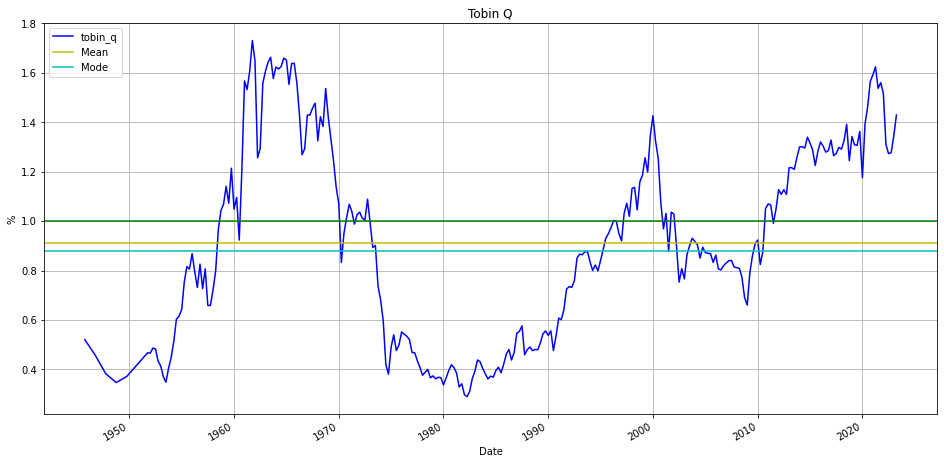

In [8]:
# Plot Tobin Q
combined['tobin_q'].plot(figsize=(16,8), title='Tobin Q', grid=True, xlabel='Date', ylabel= '%', c='b')
plt.axhline(stats['mean'], c='y', label='Mean')
plt.axhline(stats['50%'], label='Median', c='c')
plt.axhline(1, c='g')
plt.legend()

In [10]:
# Pull S&P Index historical values from yfinance API and calculate quarterly returns
ticker = "^GSPC" 
start= "1970-01-01" 
end= "2022-07-02"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.asfreq(freq='QS')
sp_history['sp_quarterly_ret'] = sp_history['Adj Close'].pct_change()
sp_history = sp_history.dropna()
sp_history.to_csv('resources/sp_history.csv')
sp_history.tail()

,Open,High,Low,Close,Adj Close,Volume,sp_quarterly_ret
Date,,,,,,,
2021-04-01,3992.780029,4020.629883,3992.780029,4019.870117,4019.870117,4.162130e+09,0.189029
2021-07-01,4300.729980,4320.660156,4300.729980,4319.939941,4319.939941,3.788230e+09,0.074647
2021-10-01,4317.160156,4375.189941,4288.520020,4357.040039,4357.040039,4.010370e+09,0.008588
2022-04-01,4540.319824,4548.700195,4507.569824,4545.859863,4545.859863,4.562940e+09,0.043337
2022-07-01,3781.000000,3829.820068,3752.100098,3825.330078,3825.330078,4.046950e+09,-0.158502


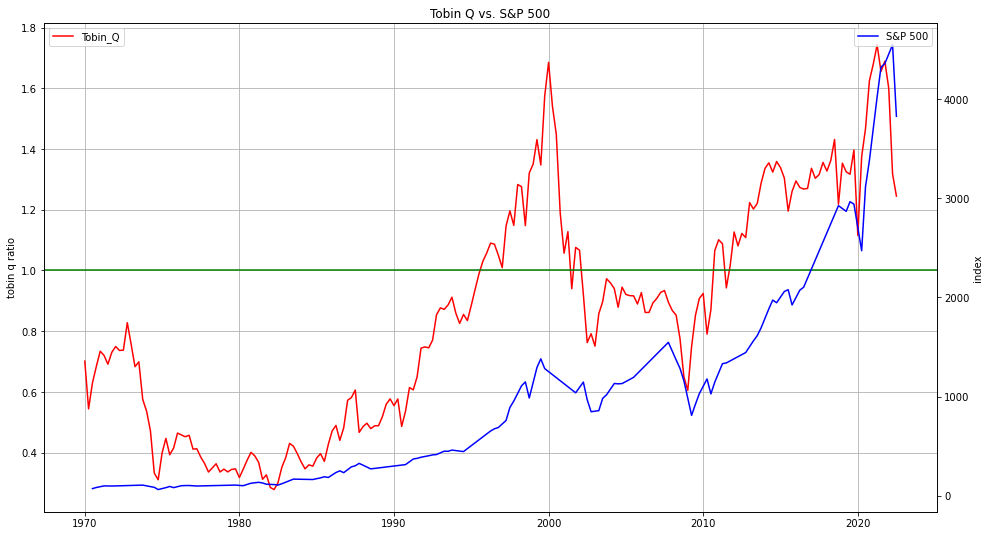

In [11]:
# Plot Tobin Q vs S&P500
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(combined['tobin_q'].loc['1970-01-01':], label ='Tobin_Q', color='r')
ax.axhline(1, c='g')
ax.set_ylabel('tobin q ratio')
ax.legend(loc='upper left')
ax.grid()

ax2 = ax.twinx()
plt.plot(sp_history['Adj Close'], label='S&P 500', color='b')
ax.set_title('Tobin Q vs. S&P 500')
ax2.set_ylabel('index')
ax2.legend(loc='upper right')

In [13]:
combined['sp_quarterly_ret'] = sp_history['sp_quarterly_ret']
combined = combined.dropna()

In [14]:
# Ten-year correlation change between Tobin Q and quartlerly S&P 500 returns
correlation = combined['tobin_q'].rolling(window=40).corr(combined['sp_quarterly_ret'])
correlation.tail()

2021-04-01    0.254308
2021-07-01    0.248219
2021-10-01    0.241658
2022-04-01    0.240492
2022-07-01    0.234462
dtype: float64

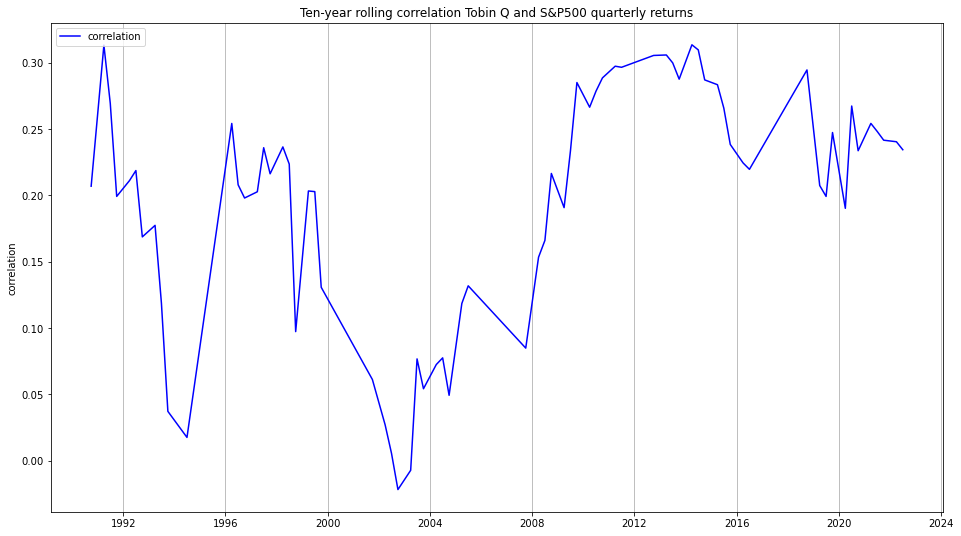

In [51]:
# Plot 10-year rolling correlation between Tobin Q and S&P500 quarterly returns
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(correlation, label ='correlation', color='b')
ax.set_ylabel('correlation')
ax.legend(loc='upper left')
ax.set_title('Ten-year rolling correlation Tobin Q and S&P500 quarterly returns')
ax.grid(axis='x')